In [63]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
from sklearn.decomposition import PCA  # Added import for PCA at the top level

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold, GroupKFold, cross_val_score, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

In [64]:
# Constants
RANDOM = 42

# Feature groups
ANTHROPOMETRY = ['person_clinic_weight', 'person_clinic_height', 'person_clinic_bmi', 
                'person_clinic_waist', 'person_clinic_hip', 'person_clinic_waist2hip']

AGE = ['person_md_age']

SEX = ['person_md_sex']

CLINICAL_BIOCHEMESTRY = ['person_clinic_pulse_1', 'person_clinic_pulse_2', 'person_clinic_pulse_3',
                         'person_clinic_pulse_1_diastolic', 'person_clinic_pulse_2_diastolic', 'person_clinic_pulse_3_diastolic',
                         'person_clinic_pulse_1_systolic', 'person_clinic_pulse_2_systolic', 'person_clinic_pulse_3_systolic',
                         'person_affinity_il6', 'person_affinity_alt',  'person_affinity_chol',
                         'person_affinity_hdl', 'person_affinity_ldl',  'person_affinity_non_hdl',
                         'person_affinity_thr', 'person_affinity_tsh', 'person_pglu',   'person_trig', 'person_ins',
                         'person_cpep',   'person_hba1c',  'person_basophils', 'person_eosinophils',
                         'person_hb', 'person_lymphocytes', 'person_mch', 'person_mcv',
                         'person_monocytes', 'person_neutrophils',   'person_nrbc', 'person_pcv',  'person_plt',
                         'person_rbc',  'person_rdw','person_wbc']

MEAL_CONTEXT = [
    'previous_meal_carbohydrate', 'previous_meal_time_since', 'meal_carb_3hr_bef', 'meal_carb_6hr_bef',
    'meal_carb_9hr_bef', 'meal_carb_12hr_bef', 'activity_post_meal_mvpa', 'activity_pre_meal_mvpa',
    'activity_pre_24h_meal_mvpa', 'activity_post_meal_light', 'activity_pre_meal_light', 'activity_pre_24h_meal_light',
    'sleep_hours_since_wake_up', 'sleep_hours_to_next_onset', 'sleep_hours_duration', 'sleep_percentage_efficiency',
    'meal_baseline_difference', 'meal_norm_start_at_midnight']

MEAL_CONTENT = ['meal_fat2carbs', 'meal_calories', 'meal_carbohydrate', 'meal_fat', 'meal_protein', 'meal_fibre', 'meal_sugar']


In [65]:

# Pearson R scorer for model evaluation
pearsonr_scorer = make_scorer(lambda x, y: scipy.stats.pearsonr(x, y)[0])

In [66]:
# Load datasets
meals_df = pd.read_csv('./sample_meals.csv')
microbiome_df = pd.read_csv('./sample_microbiome.csv')

In [67]:
# Display basic information about the datasets
print(f"Meals dataset shape: {meals_df.shape}")
print(f"Microbiome dataset shape: {microbiome_df.shape}")

Meals dataset shape: (100, 77)
Microbiome dataset shape: (100, 4877)


In [68]:
# Exploratory Data Analysis
def plot_distributions(df, target_col, n_cols=3, figsize=(18, 12)):
    """Plot distributions of target variable and key numerical features"""
    # Select numerical columns for analysis
    numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
    numerical_cols = [col for col in numerical_cols if col != target_col and df[col].notnull().sum() > df.shape[0] * 0.5]
    
    # Sample n features to plot
    n_features = min(15, len(numerical_cols))
    sampled_features = np.random.choice(numerical_cols, n_features, replace=False).tolist()
    
    # Add target column
    cols_to_plot = [target_col] + sampled_features
    
    # Calculate number of rows needed
    n_rows = int(np.ceil(len(cols_to_plot) / n_cols))
    
    # Create figure and axes
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()
    
    # Plot distributions
    for i, col in enumerate(cols_to_plot):
        if i < len(axes):
            sns.histplot(df[col].dropna(), kde=True, ax=axes[i])
            axes[i].set_title(f'Distribution of {col}')
            axes[i].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    
    # Hide unused axes
    for i in range(len(cols_to_plot), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    return fig


In [69]:

# Function to create correlation heatmap
def plot_correlation_heatmap(df, target_col, n_features=15, figsize=(12, 10)):
    """Plot correlation heatmap for target variable and most correlated features"""
    # Select numerical columns for analysis
    numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
    numerical_cols = [col for col in numerical_cols if col != target_col and df[col].notnull().sum() > df.shape[0] * 0.5]
    
    # Calculate correlations with target
    correlations = []
    for col in numerical_cols:
        corr = df[[col, target_col]].dropna().corr().iloc[0, 1]
        correlations.append((col, abs(corr)))
    
    # Sort by absolute correlation and select top n_features
    top_features = sorted(correlations, key=lambda x: x[1], reverse=True)[:n_features]
    top_feature_names = [col for col, _ in top_features]
    
    # Create correlation matrix with target and top features
    corr_df = df[[target_col] + top_feature_names].corr()
    
    # Plot heatmap
    plt.figure(figsize=figsize)
    mask = np.triu(np.ones_like(corr_df, dtype=bool))
    sns.heatmap(corr_df, annot=True, fmt=".2f", cmap="coolwarm", 
                mask=mask, vmin=-1, vmax=1)
    plt.title(f'Correlation Heatmap: {target_col} and Most Correlated Features')
    plt.tight_layout()
    return plt.gcf()


In [70]:
# Function to plot validation set results
def plot_val_set(y_true, y_pred, n, title='', figsize=(8, 8)):
    """Plot predicted vs actual values with statistics"""
    plt.figure(figsize=figsize)
    
    # Calculate range for plot limits
    x_min, x_max = np.min(y_true), np.max(y_true)
    y_min, y_max = np.min(y_pred), np.max(y_pred)
    b_min = np.min([x_min, y_min]) * 0.9
    b_max = np.max([x_max, y_max]) * 1.1
    
    # Scatter plot
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.7)
    
    # Add regression line
    regression_line = np.poly1d(np.polyfit(y_true, y_pred, 1))
    plt.plot(np.unique(y_true), regression_line(np.unique(y_true)), color='red')
    
    # Calculate statistics
    r_val, p_val = scipy.stats.pearsonr(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Add statistics annotations
    plt.annotate(f'Pearson R = {r_val:.3f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12)
    plt.annotate(f'p-value = {p_val:.2e}', xy=(0.05, 0.90), xycoords='axes fraction', fontsize=12)
    plt.annotate(f'RMSE = {rmse:.2f}', xy=(0.05, 0.85), xycoords='axes fraction', fontsize=12)
    plt.annotate(f'MAE = {mae:.2f}', xy=(0.05, 0.80), xycoords='axes fraction', fontsize=12)
    plt.annotate(f'R² = {r2:.3f}', xy=(0.05, 0.75), xycoords='axes fraction', fontsize=12)
    plt.annotate(f'n = {n}', xy=(0.05, 0.70), xycoords='axes fraction', fontsize=12)
    
    # Add diagonal line (perfect prediction)
    plt.plot([b_min, b_max], [b_min, b_max], 'k--', alpha=0.3)
    
    # Set axis limits and labels
    plt.xlim(b_min, b_max)
    plt.ylim(b_min, b_max)
    plt.xlabel('Measured Values')
    plt.ylabel('Predicted Values')
    
    if title:
        plt.title(title)
    
    plt.grid(alpha=0.3)
    return plt.gcf()


In [71]:
# Function to plot Bland-Altman plot
def plot_bland_altman(y_pred, y_true, title='', figsize=(8, 8)):
    """Create Bland-Altman plot to assess agreement between predicted and actual values"""
    plt.figure(figsize=figsize)
    
    # Calculate means and differences
    mean_values = (y_pred + y_true) / 2
    diff_values = y_pred - y_true
    
    # Calculate statistics
    mean_diff = np.mean(diff_values)
    std_diff = np.std(diff_values)
    
    # Upper and lower limits of agreement (1.96 * std)
    upper_limit = mean_diff + 1.96 * std_diff
    lower_limit = mean_diff - 1.96 * std_diff
    
    # Scatter plot
    plt.scatter(mean_values, diff_values, alpha=0.7)
    
    # Add horizontal lines for mean difference and limits of agreement
    plt.axhline(y=mean_diff, color='k', linestyle='-', label=f'Mean difference: {mean_diff:.2f}')
    plt.axhline(y=upper_limit, color='r', linestyle='--', 
                label=f'Upper limit of agreement: {upper_limit:.2f}')
    plt.axhline(y=lower_limit, color='r', linestyle='--', 
                label=f'Lower limit of agreement: {lower_limit:.2f}')
    
    # Add zero line
    plt.axhline(y=0, color='g', linestyle=':', alpha=0.5)
    
    # Set labels and title
    plt.xlabel('Mean of Predicted and Measured Values')
    plt.ylabel('Difference (Predicted - Measured)')
    
    if title:
        plt.title(f'Bland-Altman Plot: {title}')
    
    plt.legend()
    plt.grid(alpha=0.3)
    return plt.gcf()


In [72]:
# Function to plot confusion matrix for binned values
def plot_confusion_matrix(y_true, y_pred, n_bins=3, title='', figsize=(8, 7)):
    """Create a confusion matrix by binning continuous values"""
    # Define bins based on percentiles of true values
    bins = np.percentile(y_true, np.linspace(0, 100, n_bins+1))
    
    # Create bin labels
    bin_labels = [f'Bin {i+1}' for i in range(n_bins)]
    
    # Assign bin numbers to true and predicted values
    y_true_binned = np.digitize(y_true, bins[1:])
    y_pred_binned = np.digitize(y_pred, bins[1:])
    
    # Create confusion matrix
    conf_matrix = np.zeros((n_bins, n_bins))
    for i in range(len(y_true)):
        conf_matrix[y_true_binned[i]-1, y_pred_binned[i]-1] += 1
    
    # Plot confusion matrix
    plt.figure(figsize=figsize)
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues',
                xticklabels=bin_labels, yticklabels=bin_labels)
    
    # Calculate accuracy
    accuracy = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)
    
    plt.title(f'Confusion Matrix (Accuracy: {accuracy:.2f})' if not title else title)
    plt.xlabel('Predicted Bins')
    plt.ylabel('True Bins')
    
    return plt.gcf()


In [73]:
# Function to plot feature importances
def plot_feature_importance(model, feature_names, n_top=20, figsize=(10, 8)):
    """Plot feature importances from a trained model"""
    # Get feature importances
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    else:
        # For pipelines, get the last step (assuming it's the model)
        if hasattr(model, 'steps'):
            model = model.steps[-1][1]
            if hasattr(model, 'feature_importances_'):
                importances = model.feature_importances_
            else:
                return None
        else:
            return None
    
    # Sort feature importances
    indices = np.argsort(importances)[::-1]
    top_indices = indices[:n_top]
    
    # Plot
    plt.figure(figsize=figsize)
    plt.bar(range(n_top), importances[top_indices])
    plt.xticks(range(n_top), [feature_names[i] for i in top_indices], rotation=90)
    plt.title('Feature Importances')
    plt.tight_layout()
    return plt.gcf()



In [74]:
# Preprocess data
def preprocess_data():
    """Preprocess datasets and merge them"""
    # Create copies to avoid modifying originals
    meals_clean_df = meals_df.copy()
    microbiome_clean_df = microbiome_df.copy()
    
    # Perform feature reduction on microbiome data
    microbiome_bacteria_cols = microbiome_clean_df.loc[:, microbiome_clean_df.columns.str.contains('Bacteria')]
    
    # PCA pipeline for microbiome data
    pca_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scale', StandardScaler(with_mean=True, with_std=True)),
        ('pca', PCA(n_components=10, random_state=RANDOM))
    ])
    
    # Need to use fit_transform here instead of the issue in the original code
    pca_features = pca_pipe.fit_transform(microbiome_bacteria_cols)
    pca_df = pd.DataFrame(
        pca_features, 
        index=microbiome_clean_df.index,
        columns=[f'mb_pca_{i}' for i in range(10)]
    )
    
    # Join PCA features to microbiome dataframe
    for col in pca_df.columns:
        microbiome_clean_df[col] = pca_df[col].values
    
    # Merge dataframes on common identifiers
    df_clean = meals_clean_df.merge(microbiome_clean_df, on=['person_username', 'meal_study'])
    
    return df_clean



In [75]:
# Function to add calibration meals
def add_cal_meal(df_in):
    """Add calibration meal data to the dataframe"""
    def add_ogtt(df):
        avg_ogtt = df[df.meal_set_meal == 'Meal CC'].meal_iauc.mean()
        if np.isnan(avg_ogtt):  # Handle case where there are no 'Meal CC' entries
            avg_ogtt = df.meal_iauc.mean()
        dfr = df.copy()
        dfr['cal_iauc'] = avg_ogtt
        return dfr
    
    return df_in.groupby('person_username').apply(add_ogtt).reset_index(drop=True)



In [76]:
# Data preparation and feature selection
def prepare_data_for_modeling():
    """Prepare data for modeling, including preprocessing, feature selection and split"""
    # Preprocess data
    df_clean = preprocess_data()
    
    # Split data by geography
    df_uk = df_clean[df_clean.meal_study == 'PREDICT UK 1.0'].reset_index(drop=True)
    df_us = df_clean[df_clean.meal_study == 'PREDICT US 1.0'].reset_index(drop=True)
    
    # Feature groupings
    features_num = ANTHROPOMETRY + CLINICAL_BIOCHEMESTRY + AGE + MEAL_CONTEXT + MEAL_CONTENT
    features_cat = SEX
    
    # Add PCA features from microbiome data
    pca_features = [col for col in df_clean.columns if col.startswith('mb_pca_')]
    features_num += pca_features
    
    features = features_num + features_cat
    target = ['meal_iauc']
    
    # Add calibration meals
    df_uk_cal = add_cal_meal(df_uk)
    df_us_cal = add_cal_meal(df_us)
    
    # Filter data for set meals
    uk_data = df_uk_cal[df_uk_cal.meal_has_set_meal == True].reset_index(drop=True)
    us_data = df_us_cal[df_us_cal.meal_has_set_meal == True].reset_index(drop=True)
    
    # Replace infinities with NaN and drop rows with NaN in the target column
    uk_data = uk_data.replace([np.inf, -np.inf], np.nan)
    us_data = us_data.replace([np.inf, -np.inf], np.nan)
    
    uk_data = uk_data.dropna(subset=target)
    us_data = us_data.dropna(subset=target)
    
    print(f"UK data shape: {uk_data.shape}")
    print(f"US data shape: {us_data.shape}")
    
    # Return processed data with features and targets
    return {
        'uk_data': uk_data,
        'us_data': us_data,
        'features': features,
        'features_num': features_num,
        'features_cat': features_cat,
        'target': target[0]
    }



In [77]:
# Function to train and evaluate model
def train_and_evaluate_glucose_model():
    """Train and evaluate the glucose prediction model with multiple validation approaches"""
    # Prepare data
    dataset = prepare_data_for_modeling()
    uk_cohort = dataset['uk_data']
    us_cohort = dataset['us_data']
    all_features = dataset['features']
    numerical_features = dataset['features_num']
    categorical_features = dataset['features_cat']
    response_variable = dataset['target']
    
    # Include calibration meal data
    complete_feature_set = all_features + ['cal_iauc']
    
    # Feature preprocessing pipeline
    feature_processor = ColumnTransformer(
        transformers=[
            ('numerical', Pipeline([
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', StandardScaler())
            ]), numerical_features + ['cal_iauc']),
            ('categorical', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
            ]), categorical_features)
        ]
    )
    
    # Model pipeline
    glucose_model = Pipeline([
        ('feature_processor', feature_processor),
        ('regressor', RandomForestRegressor(
            n_estimators=500,
            max_depth=15,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=RANDOM,
            n_jobs=-1
        ))
    ])
    
    # Evaluation metrics
    performance_metrics = {
        'pearson_r': pearsonr_scorer,
        'neg_rmse': make_scorer(lambda y, y_pred: -np.sqrt(mean_squared_error(y, y_pred))),
        'r2': 'r2',
        'neg_mae': 'neg_mean_absolute_error'
    }
    
    # Results storage
    model_performance = {}
    
    # Cross-validation on UK data (Leave-one-user-out)
    print("\n===================== LEAVE-ONE-USER-OUT CROSS-VALIDATION =====================")
    person_based_cv = GroupKFold(n_splits=min(10, len(uk_cohort['person_username'].unique())))
    logo_results = cross_val_score(
        glucose_model,
        uk_cohort[complete_feature_set],
        uk_cohort[response_variable],
        groups=uk_cohort['person_username'],
        cv=person_based_cv,
        scoring=pearsonr_scorer
    )
    
    model_performance['logo_cv'] = {
        'mean': logo_results.mean(),
        'std': logo_results.std(),
        'scores': logo_results
    }
    
    print(f"Leave-one-user-out CV (Pearson r): {logo_results.mean():.3f} ± {logo_results.std():.3f}")
    print(f"Individual fold scores: {logo_results}")
    
    # K-fold cross-validation on UK data
    print("\n===================== K-FOLD CROSS-VALIDATION =====================")
    kfold_cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM)
    
    # Perform cross-validation with multiple metrics
    cv_metrics = {}
    for metric_name, metric_scorer in performance_metrics.items():
        metric_results = cross_val_score(
            glucose_model,
            uk_cohort[complete_feature_set],
            uk_cohort[response_variable],
            cv=kfold_cv,
            scoring=metric_scorer
        )
        cv_metrics[metric_name] = metric_results
    
    # Store and print K-fold results with all metrics
    model_performance['kfold_cv'] = {
        'pearson_r': {
            'mean': cv_metrics['pearson_r'].mean(),
            'std': cv_metrics['pearson_r'].std(),
            'scores': cv_metrics['pearson_r']
        },
        'rmse': {
            'mean': -cv_metrics['neg_rmse'].mean(),
            'std': cv_metrics['neg_rmse'].std(),
            'scores': -cv_metrics['neg_rmse']
        },
        'r2': {
            'mean': cv_metrics['r2'].mean(),
            'std': cv_metrics['r2'].std(),
            'scores': cv_metrics['r2']
        },
        'mae': {
            'mean': -cv_metrics['neg_mae'].mean(),
            'std': cv_metrics['neg_mae'].std(),
            'scores': -cv_metrics['neg_mae']
        }
    }
    
    print("\nK-fold Cross-Validation Performance Metrics:")
    print(f"  Pearson r: {cv_metrics['pearson_r'].mean():.3f} ± {cv_metrics['pearson_r'].std():.3f}")
    print(f"  RMSE: {-cv_metrics['neg_rmse'].mean():.3f} ± {cv_metrics['neg_rmse'].std():.3f}")
    print(f"  R²: {cv_metrics['r2'].mean():.3f} ± {cv_metrics['r2'].std():.3f}")
    print(f"  MAE: {-cv_metrics['neg_mae'].mean():.3f} ± {cv_metrics['neg_mae'].std():.3f}")
    print(f"  Individual fold scores (Pearson r): {cv_metrics['pearson_r']}")
    
    # Train on UK data, predict on UK data (for visualization)
    print("\n===================== INTERNAL VALIDATION =====================")
    train_features, test_features, train_responses, test_responses = train_test_split(
        uk_cohort[complete_feature_set],
        uk_cohort[response_variable],
        test_size=0.2,
        random_state=RANDOM
    )
    
    # Fit model and predict
    glucose_model.fit(train_features, train_responses)
    internal_predictions = glucose_model.predict(test_features)
    
    # Calculate internal validation metrics
    internal_pearson_r, internal_p_value = scipy.stats.pearsonr(test_responses, internal_predictions)
    internal_rmse = np.sqrt(mean_squared_error(test_responses, internal_predictions))
    internal_r2 = r2_score(test_responses, internal_predictions)
    internal_mae = mean_absolute_error(test_responses, internal_predictions)
    
    # Store results
    model_performance['uk_internal'] = {
        'y_true': test_responses,
        'y_pred': internal_predictions,
        'metrics': {
            'pearson_r': internal_pearson_r,
            'p_value': internal_p_value,
            'rmse': internal_rmse,
            'r2': internal_r2,
            'mae': internal_mae
        }
    }
    
    # Print internal validation metrics
    print("\nInternal Validation Metrics (UK Test Set):")
    print(f"  Pearson r: {internal_pearson_r:.3f} (p-value: {internal_p_value:.2e})")
    print(f"  RMSE: {internal_rmse:.3f}")
    print(f"  R²: {internal_r2:.3f}")
    print(f"  MAE: {internal_mae:.3f}")
    
    # Train on entire UK data, predict on US data (external validation)
    print("\n===================== EXTERNAL VALIDATION =====================")
    glucose_model.fit(uk_cohort[complete_feature_set], uk_cohort[response_variable])
    external_predictions = glucose_model.predict(us_cohort[complete_feature_set])
    
    # Calculate external validation metrics
    external_pearson_r, external_p_value = scipy.stats.pearsonr(us_cohort[response_variable], external_predictions)
    external_rmse = np.sqrt(mean_squared_error(us_cohort[response_variable], external_predictions))
    external_r2 = r2_score(us_cohort[response_variable], external_predictions)
    external_mae = mean_absolute_error(us_cohort[response_variable], external_predictions)
    
    # Store external validation results
    model_performance['us_external'] = {
        'y_true': us_cohort[response_variable],
        'y_pred': external_predictions,
        'metrics': {
            'pearson_r': external_pearson_r,
            'p_value': external_p_value,
            'rmse': external_rmse,
            'r2': external_r2,
            'mae': external_mae
        }
    }
    
    # Print external validation metrics
    print("\nExternal Validation Metrics (UK → US Cohort):")
    print(f"  Pearson r: {external_pearson_r:.3f} (p-value: {external_p_value:.2e})")
    print(f"  RMSE: {external_rmse:.3f}")
    print(f"  R²: {external_r2:.3f}")
    print(f"  MAE: {external_mae:.3f}")
    
    # Calculate relative improvement over baseline
    baseline_mse = np.var(us_cohort[response_variable])  # Using variance as baseline MSE
    model_mse = mean_squared_error(us_cohort[response_variable], external_predictions)
    mse_improvement = (baseline_mse - model_mse) / baseline_mse * 100
    
    print(f"  Improvement over baseline: {mse_improvement:.1f}% reduction in MSE")
    
    # Analyze error distribution
    prediction_errors = external_predictions - us_cohort[response_variable]
    error_mean = np.mean(prediction_errors)
    error_std = np.std(prediction_errors)
    error_median = np.median(prediction_errors)
    error_q25 = np.percentile(prediction_errors, 25)
    error_q75 = np.percentile(prediction_errors, 75)
    
    print("\nError Distribution (External Validation):")
    print(f"  Mean error: {error_mean:.2f}")
    print(f"  Error std: {error_std:.2f}")
    print(f"  Median error: {error_median:.2f}")
    print(f"  25th percentile: {error_q25:.2f}")
    print(f"  75th percentile: {error_q75:.2f}")
    
    # Feature importance analysis
    print("\n===================== FEATURE IMPORTANCE ANALYSIS =====================")
    # Get feature names after preprocessing
    expanded_feature_names = (
        numerical_features + ['cal_iauc'] + 
        [f"{col}_{val}" for col in categorical_features for val in uk_cohort[col].unique()[1:]]
    )
    
    # Get feature importances from the trained model
    trained_estimator = glucose_model.named_steps['regressor']
    feature_importances = trained_estimator.feature_importances_
    
    # Sort feature importances
    importance_indices = np.argsort(feature_importances)[::-1]
    top_feature_indices = importance_indices[:15]
    top_feature_names = [expanded_feature_names[i] for i in top_feature_indices]
    top_importance_values = feature_importances[top_feature_indices]
    
    # Store feature importance results
    model_performance['feature_importance'] = {
        'features': top_feature_names,
        'importances': top_importance_values,
        'all_features': expanded_feature_names,
        'all_importances': feature_importances
    }
    
    # Print top 15 important features
    print("\nTop 15 Important Features:")
    for i in range(min(15, len(top_feature_names))):
        print(f"  {i+1}. {top_feature_names[i]}: {top_importance_values[i]:.4f}")
    
    # Calculate feature importance by feature group
    feature_groups = {
        'Anthropometry': [f for f in expanded_feature_names if any(a in f for a in ANTHROPOMETRY)],
        'Clinical Biochemistry': [f for f in expanded_feature_names if any(b in f for b in CLINICAL_BIOCHEMESTRY)],
        'Age & Sex': [f for f in expanded_feature_names if any(a in f for a in AGE+SEX)],
        'Meal Context': [f for f in expanded_feature_names if any(m in f for m in MEAL_CONTEXT)],
        'Meal Content': [f for f in expanded_feature_names if any(m in f for m in MEAL_CONTENT)],
        'Microbiome': [f for f in expanded_feature_names if 'mb_pca_' in f],
        'Calibration': [f for f in expanded_feature_names if 'cal_iauc' in f]
    }
    
    group_importance = {}
    for group_name, group_features in feature_groups.items():
        # Get indices of features in this group
        group_indices = [expanded_feature_names.index(f) for f in group_features if f in expanded_feature_names]
        if group_indices:
            group_importance[group_name] = {
                'total': np.sum(feature_importances[group_indices]),
                'mean': np.mean(feature_importances[group_indices]),
                'count': len(group_indices)
            }
    
    # Sort groups by total importance
    sorted_groups = sorted(group_importance.items(), key=lambda x: x[1]['total'], reverse=True)
    
    # Print group importance
    print("\nFeature Group Importance:")
    for group_name, importance_data in sorted_groups:
        print(f"  {group_name}: {importance_data['total']:.4f} total, {importance_data['mean']:.4f} mean ({importance_data['count']} features)")
    
    # Permutation importance (more reliable than default feature importance)
    print("\nCalculating permutation importance on test set (this may take a while)...")
    perm_importance = permutation_importance(
        glucose_model, test_features, test_responses,
        n_repeats=10, random_state=RANDOM
    )
    
    # Sort permutation importance
    perm_sorted_idx = perm_importance.importances_mean.argsort()[::-1]
    perm_top_indices = perm_sorted_idx[:10]
    
    # Store permutation importance results
    model_performance['permutation_importance'] = {
        'mean': perm_importance.importances_mean,
        'std': perm_importance.importances_std,
        'top_features': [complete_feature_set[i] for i in perm_top_indices],
        'top_values': perm_importance.importances_mean[perm_top_indices]
    }
    
    # Print top 10 features by permutation importance
    print("\nTop 10 Features by Permutation Importance:")
    for i in perm_top_indices:
        print(f"  {complete_feature_set[i]}: {perm_importance.importances_mean[i]:.4f} ± {perm_importance.importances_std[i]:.4f}")
    
    # Overall model evaluation summary
    print("\n===================== MODEL PERFORMANCE SUMMARY =====================")
    print(f"Dataset Size: {len(uk_cohort)} training samples, {len(us_cohort)} validation samples")
    print(f"Feature Count: {len(complete_feature_set)} features")
    print("\nCross-Validation Performance (UK Cohort):")
    print(f"  Leave-one-user-out CV: r = {model_performance['logo_cv']['mean']:.3f} ± {model_performance['logo_cv']['std']:.3f}")
    print(f"  5-fold CV: r = {model_performance['kfold_cv']['pearson_r']['mean']:.3f} ± {model_performance['kfold_cv']['pearson_r']['std']:.3f}, R² = {model_performance['kfold_cv']['r2']['mean']:.3f}")
    print("\nExternal Validation Performance (US Cohort):")
    print(f"  Pearson r: {model_performance['us_external']['metrics']['pearson_r']:.3f}")
    print(f"  R²: {model_performance['us_external']['metrics']['r2']:.3f}")
    print(f"  RMSE: {model_performance['us_external']['metrics']['rmse']:.3f}")
    
    return glucose_model, model_performance, expanded_feature_names


In [78]:
def create_visualizations(model_performance, uk_cohort, us_cohort, feature_names):
    """Create and display visualizations of model performance"""
    # Internal validation scatter plot
    print("\nCreating visualization: UK internal validation scatter plot")
    internal_true = model_performance['uk_internal']['y_true']
    internal_pred = model_performance['uk_internal']['y_pred']
    internal_metrics = model_performance['uk_internal']['metrics']
    
    plt.figure(figsize=(10, 8))
    
    # Calculate range for plot limits
    x_min, x_max = np.min(internal_true), np.max(internal_true)
    y_min, y_max = np.min(internal_pred), np.max(internal_pred)
    b_min = np.min([x_min, y_min]) * 0.9
    b_max = np.max([x_max, y_max]) * 1.1
    
    # Scatter plot
    sns.scatterplot(x=internal_true, y=internal_pred, alpha=0.7)
    
    # Add regression line
    regression_line = np.poly1d(np.polyfit(internal_true, internal_pred, 1))
    plt.plot(np.unique(internal_true), regression_line(np.unique(internal_true)), color='red')
    
    # Add statistics annotations
    plt.annotate(f'Pearson r = {internal_metrics["pearson_r"]:.3f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12)
    plt.annotate(f'p-value = {internal_metrics["p_value"]:.2e}', xy=(0.05, 0.90), xycoords='axes fraction', fontsize=12)
    plt.annotate(f'RMSE = {internal_metrics["rmse"]:.2f}', xy=(0.05, 0.85), xycoords='axes fraction', fontsize=12)
    plt.annotate(f'R² = {internal_metrics["r2"]:.3f}', xy=(0.05, 0.80), xycoords='axes fraction', fontsize=12)
    plt.annotate(f'MAE = {internal_metrics["mae"]:.2f}', xy=(0.05, 0.75), xycoords='axes fraction', fontsize=12)
    plt.annotate(f'n = {len(internal_true)}', xy=(0.05, 0.70), xycoords='axes fraction', fontsize=12)
    
    # Add diagonal line (perfect prediction)
    plt.plot([b_min, b_max], [b_min, b_max], 'k--', alpha=0.3)
    
    # Set axis limits and labels
    plt.xlim(b_min, b_max)
    plt.ylim(b_min, b_max)
    plt.xlabel('Measured Glucose Response (iAUC)')
    plt.ylabel('Predicted Glucose Response (iAUC)')
    plt.title('UK Internal Validation: Predicted vs. Measured Glucose Response')
    
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('uk_internal_validation.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # External validation scatter plot
    print("\nCreating visualization: US external validation scatter plot")
    external_true = model_performance['us_external']['y_true']
    external_pred = model_performance['us_external']['y_pred']
    external_metrics = model_performance['us_external']['metrics']
    
    plt.figure(figsize=(10, 8))
    
    # Calculate range for plot limits
    x_min, x_max = np.min(external_true), np.max(external_true)
    y_min, y_max = np.min(external_pred), np.max(external_pred)
    b_min = np.min([x_min, y_min]) * 0.9
    b_max = np.max([x_max, y_max]) * 1.1
    
    # Scatter plot
    sns.scatterplot(x=external_true, y=external_pred, alpha=0.7)
    
    # Add regression line
    regression_line = np.poly1d(np.polyfit(external_true, external_pred, 1))
    plt.plot(np.unique(external_true), regression_line(np.unique(external_true)), color='red')
    
    # Add statistics annotations
    plt.annotate(f'Pearson r = {external_metrics["pearson_r"]:.3f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12)
    plt.annotate(f'p-value = {external_metrics["p_value"]:.2e}', xy=(0.05, 0.90), xycoords='axes fraction', fontsize=12)
    plt.annotate(f'RMSE = {external_metrics["rmse"]:.2f}', xy=(0.05, 0.85), xycoords='axes fraction', fontsize=12)
    plt.annotate(f'R² = {external_metrics["r2"]:.3f}', xy=(0.05, 0.80), xycoords='axes fraction', fontsize=12)
    plt.annotate(f'MAE = {external_metrics["mae"]:.2f}', xy=(0.05, 0.75), xycoords='axes fraction', fontsize=12)
    plt.annotate(f'n = {len(external_true)}', xy=(0.05, 0.70), xycoords='axes fraction', fontsize=12)
    
    # Add diagonal line (perfect prediction)
    plt.plot([b_min, b_max], [b_min, b_max], 'k--', alpha=0.3)
    
    # Set axis limits and labels
    plt.xlim(b_min, b_max)
    plt.ylim(b_min, b_max)
    plt.xlabel('Measured Glucose Response (iAUC)')
    plt.ylabel('Predicted Glucose Response (iAUC)')
    plt.title('US External Validation: Predicted vs. Measured Glucose Response')
    
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('us_external_validation.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Create binned confusion matrices
    print("\nCreating visualization: Confusion matrices")
 


=================== DATA PREPARATION ===================


/var/folders/6x/nmnllw9j0q1f4j26gdms4n4r0000gp/T/ipykernel_95866/3533712535.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df_in.groupby('person_username').apply(add_ogtt).reset_index(drop=True)
/var/folders/6x/nmnllw9j0q1f4j26gdms4n4r0000gp/T/ipykernel_95866/3533712535.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df_in.groupby('person_username').apply(add_ogtt).reset_index(drop=

UK data shape: (26, 4963)
US data shape: (40, 4963)

=================== DATA EXPLORATION ===================
UK meal data shape: (26, 4963)
US meal data shape: (40, 4963)

Glucose Response (meal_iauc) Statistics:

UK Cohort:
  count: 26.00
  mean: 8366.48
  std: 5513.19
  min: 1054.90
  25%: 3387.62
  50%: 7871.08
  75%: 12269.78
  max: 18792.00

US Cohort:
  count: 40.00
  mean: 7954.40
  std: 6036.69
  min: 0.00
  25%: 3840.00
  50%: 6754.60
  75%: 10845.00
  max: 23012.63

Response Distribution by Tertiles:

UK Cohort:
  Low: 9 samples (34.6%)
  High: 9 samples (34.6%)
  Medium: 8 samples (30.8%)

US Cohort:
  High: 14 samples (35.0%)
  Low: 13 samples (32.5%)
  Medium: 13 samples (32.5%)


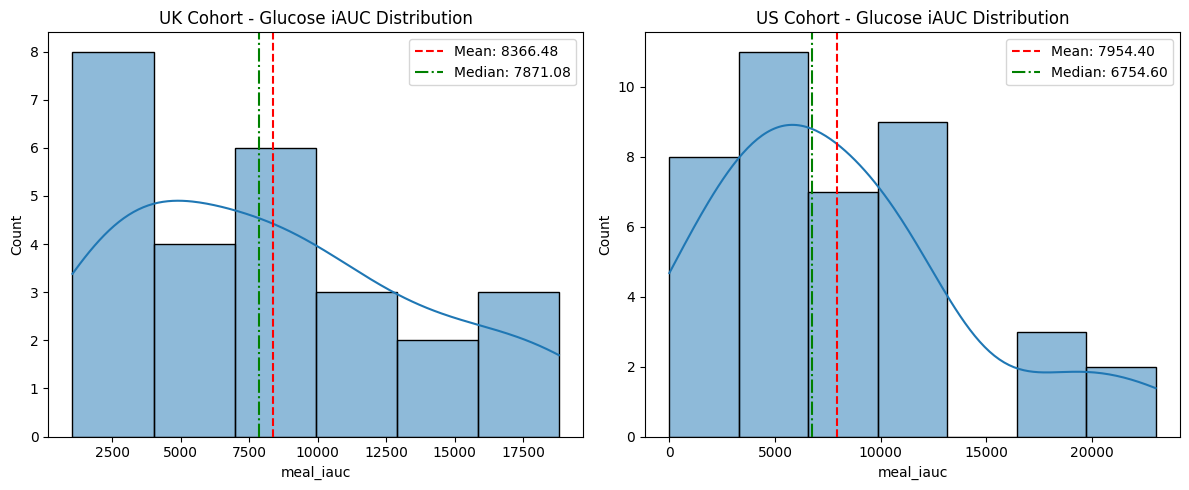


=================== MODEL TRAINING AND EVALUATION ===================
Training Random Forest model for glucose response prediction...
UK data shape: (26, 4963)
US data shape: (40, 4963)

===================== LEAVE-ONE-USER-OUT CROSS-VALIDATION =====================


/var/folders/6x/nmnllw9j0q1f4j26gdms4n4r0000gp/T/ipykernel_95866/3533712535.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df_in.groupby('person_username').apply(add_ogtt).reset_index(drop=True)
/var/folders/6x/nmnllw9j0q1f4j26gdms4n4r0000gp/T/ipykernel_95866/3533712535.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df_in.groupby('person_username').apply(add_ogtt).reset_index(drop=

Leave-one-user-out CV (Pearson r): 0.621 ± 0.691
Individual fold scores: [-0.99999947  0.99060314 -0.44849907  0.99886     0.99998207  0.66726775
  1.          1.          1.          1.        ]

===================== K-FOLD CROSS-VALIDATION =====================

K-fold Cross-Validation Performance Metrics:
  Pearson r: 0.907 ± 0.075
  RMSE: 3145.274 ± 1693.373
  R²: 0.565 ± 0.270
  MAE: 2740.479 ± 1476.165
  Individual fold scores (Pearson r): [0.95149523 0.97349415 0.85528171 0.96950874 0.78340013]

===================== INTERNAL VALIDATION =====================

Internal Validation Metrics (UK Test Set):
  Pearson r: 0.930 (p-value: 7.19e-03)
  RMSE: 3746.249
  R²: 0.560
  MAE: 3394.539

===================== EXTERNAL VALIDATION =====================

External Validation Metrics (UK → US Cohort):
  Pearson r: 0.752 (p-value: 2.21e-08)
  RMSE: 4025.911
  R²: 0.544
  MAE: 3148.611
  Improvement over baseline: 54.4% reduction in MSE

Error Distribution (External Validation):
  Mean e

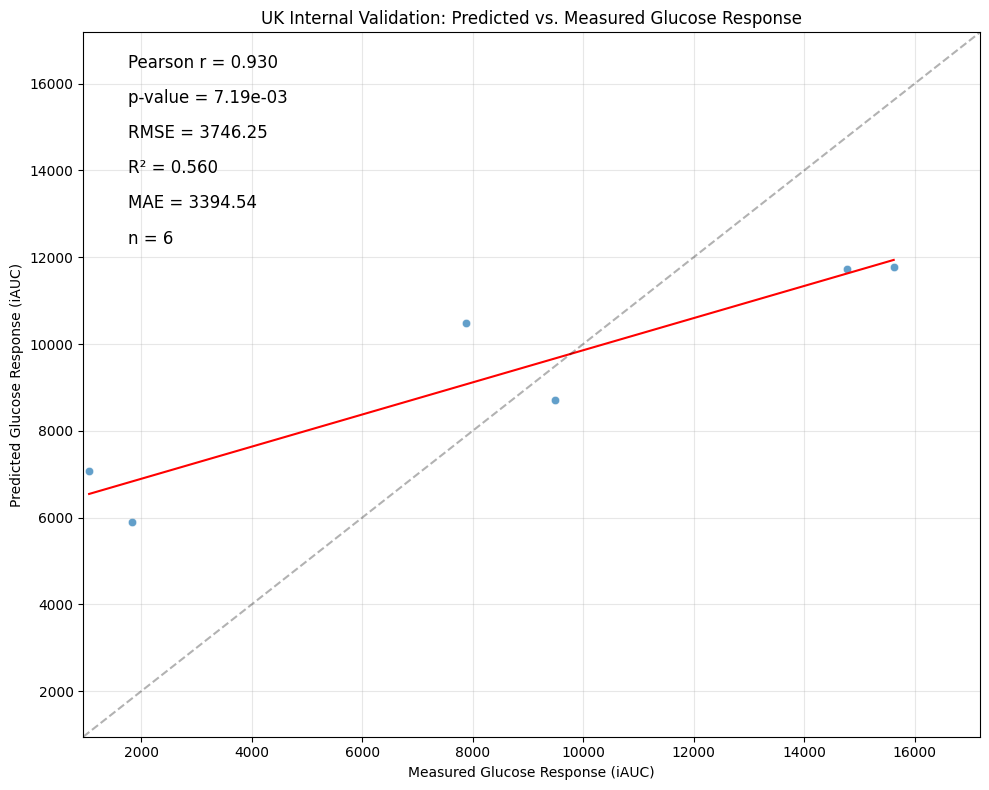


Creating visualization: US external validation scatter plot


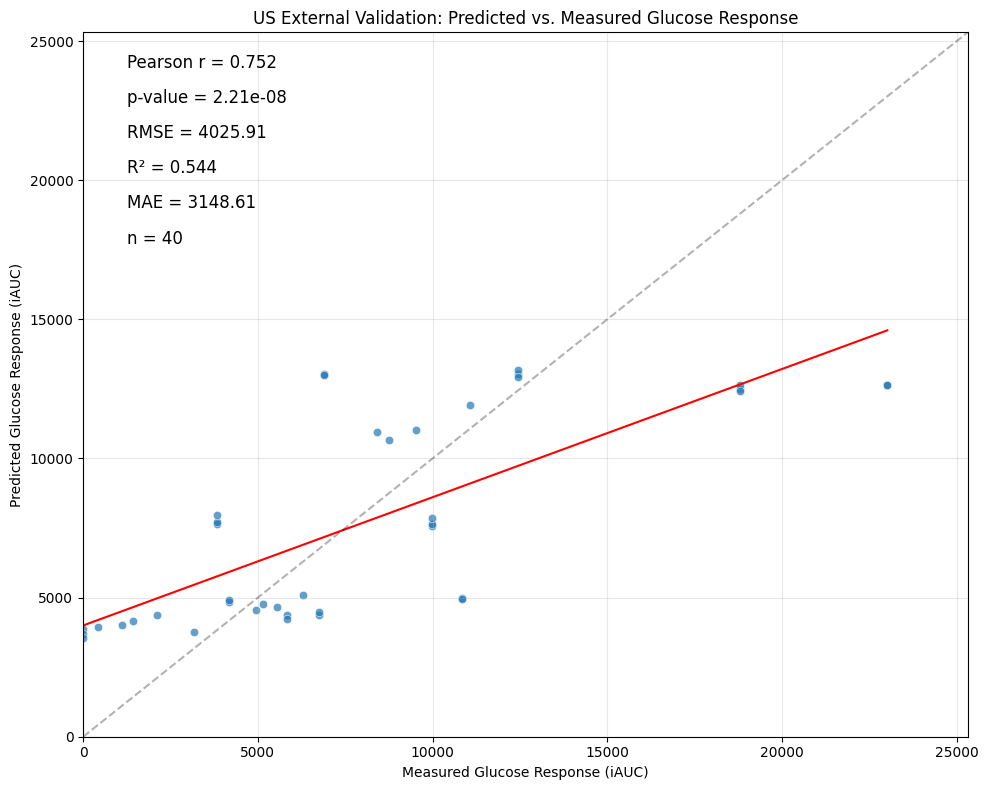


Creating visualization: Confusion matrices

=================== FINAL PERFORMANCE REPORT ===================

UK Internal Validation Metrics:
  pearson_r: 0.9300
  p_value: 0.0072
  rmse: 3746.2485
  r2: 0.5601
  mae: 3394.5392

US External Validation Metrics:
  pearson_r: 0.7521
  p_value: 0.0000
  rmse: 4025.9106
  r2: 0.5438
  mae: 3148.6109

Feature Group Contribution:
  Calibration: 68.5% (from 1 features)
  Clinical: 17.8% (from 36 features)
  Meal Context: 5.2% (from 18 features)
  Microbiome: 4.0% (from 10 features)
  Demographics: 2.0% (from 2 features)
  Anthropometric: 1.3% (from 6 features)
  Meal Content: 1.2% (from 8 features)

=== Subgroup Analysis ===
Analyzing age group: 40-60 (n = 14)


/Users/KUMAAB8/Documents/abhishek/ut-austin-assignments/eathealthy-ai/eatsmart-ai/gi-personalize-app/eatsmartvenv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


  Pearson r: 0.044 ± 0.834
Skipping age group <40 - insufficient data
Skipping age group >60 - insufficient data
Analyzing gender: F (n = 21)
  Pearson r: 0.842 ± 0.183
Skipping gender M - insufficient data
Analyzing BMI group: Normal (n = 14)
  Pearson r: 0.730 ± 0.384
Skipping BMI group Overweight - insufficient data
Skipping BMI group Obese - insufficient data
Skipping BMI group Underweight - insufficient data

=== Feature Ablation Study ===
Evaluating feature group: All Features (80 features)
  Pearson r: 0.907 ± 0.075
Evaluating feature group: No Microbiome (70 features)
  Pearson r: 0.908 ± 0.077
Evaluating feature group: No Meal Context (62 features)
  Pearson r: 0.900 ± 0.090
Evaluating feature group: No Meal Content (73 features)
  Pearson r: 0.910 ± 0.076
Evaluating feature group: No Anthropometry (74 features)
  Pearson r: 0.900 ± 0.085
Evaluating feature group: No Clinical Biochemistry (44 features)
  Pearson r: 0.917 ± 0.072
Evaluating feature group: No Calibration Meal (7

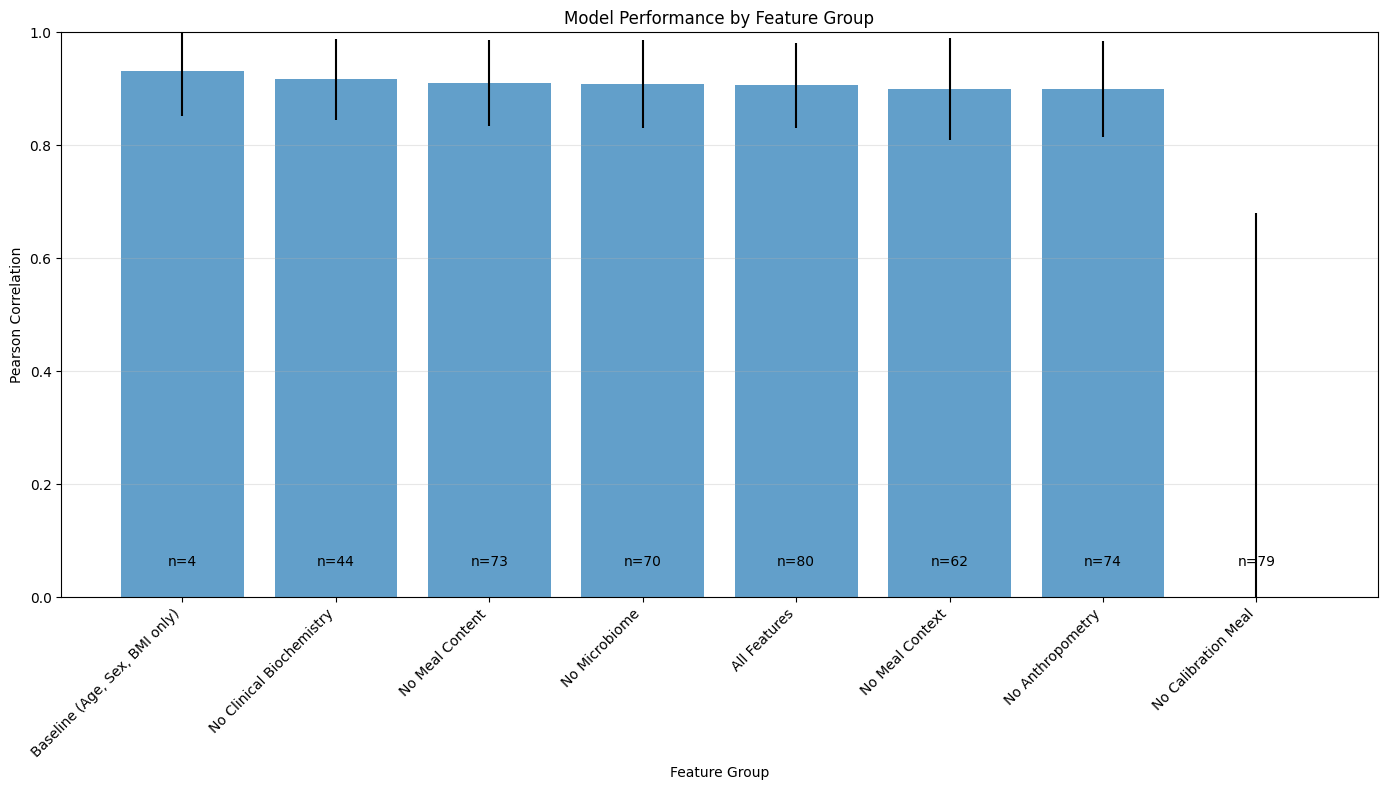


=== Analysis Complete ===


In [79]:
# Main execution
def main():
    """Main function to execute the entire analysis pipeline"""
    # Load and preprocess data
    print("\n=================== DATA PREPARATION ===================")
    dataset = prepare_data_for_modeling()
    uk_cohort = dataset['uk_data']
    us_cohort = dataset['us_data']
    
    # Initial data exploration
    print("\n=================== DATA EXPLORATION ===================")
    print(f"UK meal data shape: {uk_cohort.shape}")
    print(f"US meal data shape: {us_cohort.shape}")
    
    # Basic statistics of target variable
    uk_stats = uk_cohort['meal_iauc'].describe()
    us_stats = us_cohort['meal_iauc'].describe()
    
    print("\nGlucose Response (meal_iauc) Statistics:")
    print("\nUK Cohort:")
    for stat_name, stat_value in uk_stats.items():
        print(f"  {stat_name}: {stat_value:.2f}")
    
    print("\nUS Cohort:")
    for stat_name, stat_value in us_stats.items():
        print(f"  {stat_name}: {stat_value:.2f}")
    
    # Check class balance
    uk_tertiles = pd.qcut(uk_cohort['meal_iauc'], 3, labels=["Low", "Medium", "High"])
    us_tertiles = pd.qcut(us_cohort['meal_iauc'], 3, labels=["Low", "Medium", "High"])
    
    print("\nResponse Distribution by Tertiles:")
    print("\nUK Cohort:")
    for label, count in uk_tertiles.value_counts().items():
        print(f"  {label}: {count} samples ({count/len(uk_tertiles)*100:.1f}%)")
    
    print("\nUS Cohort:")
    for label, count in us_tertiles.value_counts().items():
        print(f"  {label}: {count} samples ({count/len(us_tertiles)*100:.1f}%)")
    
    # Display distributions of target variable
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(uk_cohort['meal_iauc'], kde=True)
    plt.title('UK Cohort - Glucose iAUC Distribution')
    plt.axvline(uk_cohort['meal_iauc'].mean(), color='red', linestyle='--', label=f'Mean: {uk_cohort["meal_iauc"].mean():.2f}')
    plt.axvline(uk_cohort['meal_iauc'].median(), color='green', linestyle='-.', label=f'Median: {uk_cohort["meal_iauc"].median():.2f}')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    sns.histplot(us_cohort['meal_iauc'], kde=True)
    plt.title('US Cohort - Glucose iAUC Distribution')
    plt.axvline(us_cohort['meal_iauc'].mean(), color='red', linestyle='--', label=f'Mean: {us_cohort["meal_iauc"].mean():.2f}')
    plt.axvline(us_cohort['meal_iauc'].median(), color='green', linestyle='-.', label=f'Median: {us_cohort["meal_iauc"].median():.2f}')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Train and evaluate model
    print("\n=================== MODEL TRAINING AND EVALUATION ===================")
    print("Training Random Forest model for glucose response prediction...")
    glucose_model, model_performance, expanded_feature_names = train_and_evaluate_glucose_model()
    
    # Create visualizations
    print("\n=================== CREATING VISUALIZATIONS ===================")
    create_visualizations(model_performance, uk_cohort, us_cohort, expanded_feature_names)
    
    # Print final performance report
    print("\n=================== FINAL PERFORMANCE REPORT ===================")
    print("\nUK Internal Validation Metrics:")
    for metric_name, metric_value in model_performance['uk_internal']['metrics'].items():
        if isinstance(metric_value, float):
            print(f"  {metric_name}: {metric_value:.4f}")
    
    print("\nUS External Validation Metrics:")
    for metric_name, metric_value in model_performance['us_external']['metrics'].items():
        if isinstance(metric_value, float):
            print(f"  {metric_name}: {metric_value:.4f}")
    
    print("\nFeature Group Contribution:")
    # Calculate feature group importance
    all_feature_names = model_performance['feature_importance']['all_features']
    all_importances = model_performance['feature_importance']['all_importances']
    
    feature_categories = {
        'Anthropometric': [f for f in all_feature_names if any(a in f for a in ANTHROPOMETRY)],
        'Clinical': [f for f in all_feature_names if any(c in f for c in CLINICAL_BIOCHEMESTRY)],
        'Demographics': [f for f in all_feature_names if any(d in f for d in AGE+SEX)],
        'Meal Context': [f for f in all_feature_names if any(m in f for m in MEAL_CONTEXT)],
        'Meal Content': [f for f in all_feature_names if any(m in f for m in MEAL_CONTENT)],
        'Microbiome': [f for f in all_feature_names if 'mb_pca_' in f],
        'Calibration': [f for f in all_feature_names if 'cal_iauc' in f]
    }
    
    group_contributions = {}
    for category_name, category_features in feature_categories.items():
        # Get indices of features in this category
        feature_indices = [all_feature_names.index(f) for f in category_features if f in all_feature_names]
        if feature_indices:
            total_importance = sum(all_importances[i] for i in feature_indices)
            group_contributions[category_name] = {
                'total_importance': total_importance,
                'relative_importance': total_importance / sum(all_importances) * 100,
                'feature_count': len(feature_indices)
            }
    
    # Print category contributions
    for category, contribution in sorted(group_contributions.items(), key=lambda x: x[1]['relative_importance'], reverse=True):
        print(f"  {category}: {contribution['relative_importance']:.1f}% (from {contribution['feature_count']} features)")
        
    # Scenario analysis: Subgroup performance
    print("\n=== Subgroup Analysis ===")
    
    # Define age groups
    uk_cohort['age_group'] = pd.cut(uk_cohort['person_md_age'], bins=[0, 40, 60, 100], labels=['<40', '40-60', '>60'])
    
    # Performance by age group
    age_results = {}
    for age_group in uk_cohort['age_group'].unique():
        if pd.isna(age_group):
            continue
            
        # Filter data by age group
        group_data = uk_cohort[uk_cohort['age_group'] == age_group]
        
        if len(group_data) < 10:
            print(f"Skipping age group {age_group} - insufficient data")
            continue
            
        print(f"Analyzing age group: {age_group} (n = {len(group_data)})")
        
        # Cross-validation for this group
        cv = KFold(n_splits=min(5, len(group_data)), shuffle=True, random_state=RANDOM)
        group_scores = cross_val_score(
            glucose_model, 
            group_data[dataset['features'] + ['cal_iauc']], 
            group_data[dataset['target']], 
            cv=cv, 
            scoring=pearsonr_scorer
        )
        
        age_results[age_group] = {
            'mean': group_scores.mean(),
            'std': group_scores.std(),
            'n': len(group_data)
        }
        
        print(f"  Pearson r: {group_scores.mean():.3f} ± {group_scores.std():.3f}")
    
    # Visualize age group performance
    if len(age_results) > 1:
        plt.figure(figsize=(10, 6))
        
        age_groups = list(age_results.keys())
        means = [age_results[g]['mean'] for g in age_groups]
        stds = [age_results[g]['std'] for g in age_groups]
        counts = [age_results[g]['n'] for g in age_groups]
        
        # Bar plot
        bars = plt.bar(age_groups, means, yerr=stds, alpha=0.7)
        
        # Add count labels
        for i, (bar, count) in enumerate(zip(bars, counts)):
            plt.text(bar.get_x() + bar.get_width()/2, 0.05, f'n={count}', 
                     ha='center', va='bottom', color='black')
        
        plt.xlabel('Age Group')
        plt.ylabel('Pearson Correlation')
        plt.title('Model Performance by Age Group')
        plt.ylim(0, 1)
        plt.grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('age_group_performance.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    # Gender analysis
    gender_results = {}
    for gender in uk_cohort['person_md_sex'].unique():
        if pd.isna(gender):
            continue
            
        # Filter data by gender
        group_data = uk_cohort[uk_cohort['person_md_sex'] == gender]
        
        if len(group_data) < 10:
            print(f"Skipping gender {gender} - insufficient data")
            continue
            
        print(f"Analyzing gender: {gender} (n = {len(group_data)})")
        
        # Cross-validation for this group
        cv = KFold(n_splits=min(5, len(group_data)), shuffle=True, random_state=RANDOM)
        group_scores = cross_val_score(
            glucose_model, 
            group_data[dataset['features'] + ['cal_iauc']], 
            group_data[dataset['target']], 
            cv=cv, 
            scoring=pearsonr_scorer
        )
        
        gender_results[gender] = {
            'mean': group_scores.mean(),
            'std': group_scores.std(),
            'n': len(group_data)
        }
        
        print(f"  Pearson r: {group_scores.mean():.3f} ± {group_scores.std():.3f}")
    
    # Visualize gender performance
    if len(gender_results) > 1:
        plt.figure(figsize=(8, 6))
        
        genders = list(gender_results.keys())
        means = [gender_results[g]['mean'] for g in genders]
        stds = [gender_results[g]['std'] for g in genders]
        counts = [gender_results[g]['n'] for g in genders]
        
        # Bar plot
        bars = plt.bar(genders, means, yerr=stds, alpha=0.7)
        
        # Add count labels
        for i, (bar, count) in enumerate(zip(bars, counts)):
            plt.text(bar.get_x() + bar.get_width()/2, 0.05, f'n={count}', 
                     ha='center', va='bottom', color='black')
        
        plt.xlabel('Gender')
        plt.ylabel('Pearson Correlation')
        plt.title('Model Performance by Gender')
        plt.ylim(0, 1)
        plt.grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('gender_performance.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    # BMI analysis
    uk_cohort['bmi_group'] = pd.cut(
        uk_cohort['person_clinic_bmi'], 
        bins=[0, 18.5, 25, 30, 100], 
        labels=['Underweight', 'Normal', 'Overweight', 'Obese']
    )
    
    bmi_results = {}
    for bmi_group in uk_cohort['bmi_group'].unique():
        if pd.isna(bmi_group):
            continue
            
        # Filter data by BMI group
        group_data = uk_cohort[uk_cohort['bmi_group'] == bmi_group]
        
        if len(group_data) < 10:
            print(f"Skipping BMI group {bmi_group} - insufficient data")
            continue
            
        print(f"Analyzing BMI group: {bmi_group} (n = {len(group_data)})")
        
        # Cross-validation for this group
        cv = KFold(n_splits=min(5, len(group_data)), shuffle=True, random_state=RANDOM)
        group_scores = cross_val_score(
            glucose_model, 
            group_data[dataset['features'] + ['cal_iauc']], 
            group_data[dataset['target']], 
            cv=cv, 
            scoring=pearsonr_scorer
        )
        
        bmi_results[bmi_group] = {
            'mean': group_scores.mean(),
            'std': group_scores.std(),
            'n': len(group_data)
        }
        
        print(f"  Pearson r: {group_scores.mean():.3f} ± {group_scores.std():.3f}")
    
    # Visualize BMI group performance
    if len(bmi_results) > 1:
        plt.figure(figsize=(12, 6))
        
        bmi_groups = list(bmi_results.keys())
        means = [bmi_results[g]['mean'] for g in bmi_groups]
        stds = [bmi_results[g]['std'] for g in bmi_groups]
        counts = [bmi_results[g]['n'] for g in bmi_groups]
        
        # Bar plot
        bars = plt.bar(bmi_groups, means, yerr=stds, alpha=0.7)
        
        # Add count labels
        for i, (bar, count) in enumerate(zip(bars, counts)):
            plt.text(bar.get_x() + bar.get_width()/2, 0.05, f'n={count}', 
                     ha='center', va='bottom', color='black')
        
        plt.xlabel('BMI Group')
        plt.ylabel('Pearson Correlation')
        plt.title('Model Performance by BMI Group')
        plt.ylim(0, 1)
        plt.grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('bmi_group_performance.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    # Feature ablation study
    print("\n=== Feature Ablation Study ===")
    feature_groups = {
        'All Features': dataset['features'] + ['cal_iauc'],
        'No Microbiome': [f for f in dataset['features'] + ['cal_iauc'] if not f.startswith('mb_pca_')],
        'No Meal Context': [f for f in dataset['features'] + ['cal_iauc'] if f not in MEAL_CONTEXT],
        'No Meal Content': [f for f in dataset['features'] + ['cal_iauc'] if f not in MEAL_CONTENT],
        'No Anthropometry': [f for f in dataset['features'] + ['cal_iauc'] if f not in ANTHROPOMETRY],
        'No Clinical Biochemistry': [f for f in dataset['features'] + ['cal_iauc'] if f not in CLINICAL_BIOCHEMESTRY],
        'No Calibration Meal': [f for f in dataset['features'] + ['cal_iauc'] if f != 'cal_iauc'],
        'Baseline (Age, Sex, BMI only)': ['person_md_age', 'person_clinic_bmi', 'person_md_sex', 'cal_iauc']
    }
    
    ablation_results = {}
    for group_name, feature_subset in feature_groups.items():
        print(f"Evaluating feature group: {group_name} ({len(feature_subset)} features)")
        
        # Cross-validation
        cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM)
        
        # Need to adjust preprocessing for the feature subset
        num_features = [f for f in feature_subset if f in dataset['features_num'] + ['cal_iauc']]
        cat_features = [f for f in feature_subset if f in dataset['features_cat']]
        
        # New preprocessing pipeline
        preprocessing = ColumnTransformer(
            transformers=[
                ('num', Pipeline([
                    ('imputer', SimpleImputer(strategy='mean')),
                    ('scaler', StandardScaler())
                ]), num_features),
                ('cat', Pipeline([
                    ('imputer', SimpleImputer(strategy='most_frequent')),
                    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
                ]), cat_features)
            ],
            remainder='drop'
        )
        
        # Model pipeline
        pipeline = Pipeline([
            ('preprocessing', preprocessing),
            ('regressor', RandomForestRegressor(
                n_estimators=500,
                max_depth=15,
                min_samples_split=5,
                min_samples_leaf=2,
                random_state=RANDOM,
                n_jobs=-1
            ))
        ])
        
        # Evaluate
        scores = cross_val_score(
            pipeline, 
            uk_cohort[feature_subset], 
            uk_cohort[dataset['target']], 
            cv=cv, 
            scoring=pearsonr_scorer
        )
        
        ablation_results[group_name] = {
            'mean': scores.mean(),
            'std': scores.std(),
            'feature_count': len(feature_subset)
        }
        
        print(f"  Pearson r: {scores.mean():.3f} ± {scores.std():.3f}")
    
    # Visualize ablation study
    plt.figure(figsize=(14, 8))
    
    groups = list(ablation_results.keys())
    means = [ablation_results[g]['mean'] for g in groups]
    stds = [ablation_results[g]['std'] for g in groups]
    feature_counts = [ablation_results[g]['feature_count'] for g in groups]
    
    # Sort by mean performance
    sorted_indices = np.argsort(means)[::-1]
    groups = [groups[i] for i in sorted_indices]
    means = [means[i] for i in sorted_indices]
    stds = [stds[i] for i in sorted_indices]
    feature_counts = [feature_counts[i] for i in sorted_indices]
    
    # Bar plot
    bars = plt.bar(groups, means, yerr=stds, alpha=0.7)
    
    # Add feature count labels
    for i, (bar, count) in enumerate(zip(bars, feature_counts)):
        plt.text(bar.get_x() + bar.get_width()/2, 0.05, f'n={count}', 
                 ha='center', va='bottom', color='black')
    
    plt.xlabel('Feature Group')
    plt.ylabel('Pearson Correlation')
    plt.title('Model Performance by Feature Group')
    plt.ylim(0, 1)
    plt.grid(axis='y', alpha=0.3)
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig('feature_ablation.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n=== Analysis Complete ===")
    return glucose_model, model_performance

# Entry point for the script
if __name__ == "__main__":
    main()# Function to create visualizations